In [226]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 150

In [396]:
import numpy as np
import pandas as pd

import ipywidgets as widgets
from ipywidgets import interact, fixed


# Data
# from transat.data import HYPOTHETICAL_SUBMISSION_DATE
from transat.data.load import download_historical, load_historical
from transat.data.split import split_historical
from transat.data.transform import preprocess_historical_basic, dataframe_to_array, preprocess_historical_lstm

# Metric
from transat.metric import mae

# Scenario/Simulation
from transat.data.scenario import generate_scenario

In [229]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [230]:
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-10-31")
CASES_COL = ["PredictionRatio"]

In [231]:
download_historical()
df = load_historical()

In [232]:
# df = preprocess_historical_basic(df, norm_by_pop=False)
df = preprocess_historical_lstm(df)
print(df.columns)

Index(['CountryName', 'RegionName', 'GeoID', 'Date', 'ConfirmedCases',
       'ConfirmedDeaths', 'Population', 'C1_School closing',
       'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
       'NewCases', 'NewDeaths', 'SmoothNewCases', 'SmoothNewDeaths',
       'CaseRatio', 'DeathRatio', 'ProportionInfected', 'PredictionRatio'],
      dtype='object')


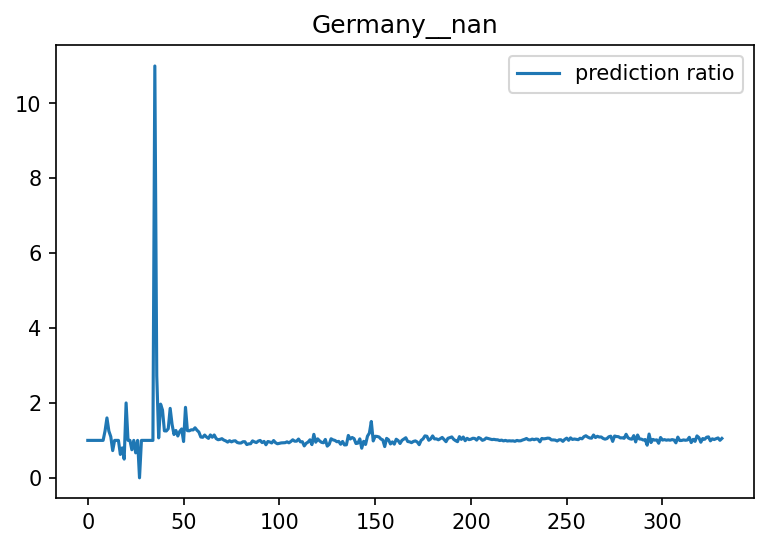

In [207]:
plt.figure()
geo_id = "Germany__nan"

plt.title(geo_id)

y = df[df.GeoID == geo_id].PredictionRatio.tolist()

plt.plot(y, label="prediction ratio")

plt.legend()
plt.show()

In [233]:
def most_affected_geos(df, nb_geos, min_historical_days):
    """
    Returns the list of most affected countries, in terms of confirmed deaths.
    :param df: the data frame containing the historical data
    :param nb_geos: the number of geos to return
    :param min_historical_days: the minimum days of historical data the countries must have
    :return: a list of country names of size nb_countries if there were enough, and otherwise a list of all the
    country names that have at least min_look_back_days data points.
    """
    # By default use most affected geos with enough history
    gdf = df.groupby('GeoID')['ConfirmedDeaths'].agg(['max', 'count']).sort_values(by='max', ascending=False)
    filtered_gdf = gdf[gdf["count"] > min_historical_days]
    geos = list(filtered_gdf.head(nb_geos).index)
    return geos

In [234]:
geo_ids = most_affected_geos(df, 20, 21)
print(geo_ids)

['United States__nan', 'Brazil__nan', 'India__nan', 'Mexico__nan', 'Italy__nan', 'United Kingdom__nan', 'France__nan', 'United Kingdom__England', 'Iran__nan', 'Russia__nan', 'Spain__nan', 'Argentina__nan', 'Colombia__nan', 'Peru__nan', 'United States__New York', 'Germany__nan', 'United States__Texas', 'Poland__nan', 'South Africa__nan', 'United States__California']


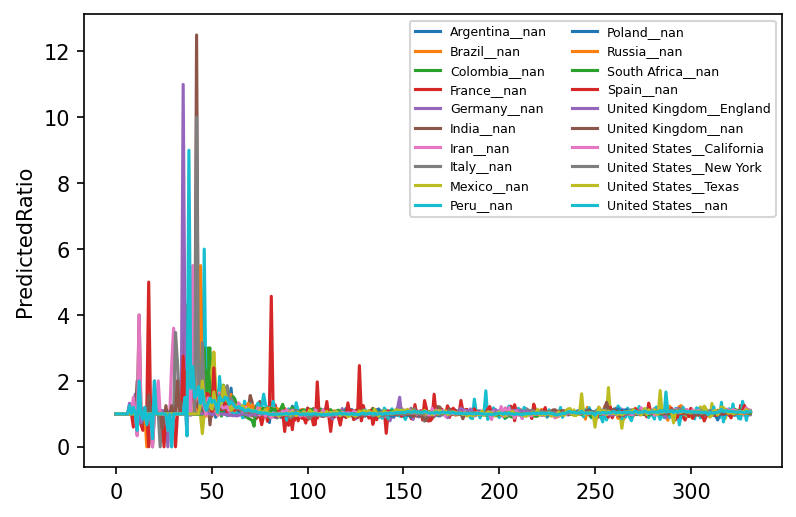

In [451]:
plt.figure()

for geo_id in geo_ids:

    y = df[df.GeoID == geo_id].PredictionRatio.tolist()

    plt.plot(y, label=geo_id)

plt.ylabel("PredictedRatio")
plt.legend(fontsize=6, ncol=2)
plt.show()

In [241]:
# geo_ids = ["France__nan", "Germany__nan", "Canada__nan", "United States__nan"]
df = df[df.GeoID.isin(geo_ids)]

In [242]:
print("Spliting at : ", HYPOTHETICAL_SUBMISSION_DATE)
df_train, df_test = split_historical(df, HYPOTHETICAL_SUBMISSION_DATE)

Spliting at :  2020-10-31


In [243]:
nb_lookback_days = 21
nb_lookahead_days = 1
sequence_format = True
neg_npis = False

(X_train, y_train), (X_cols, y_col) = dataframe_to_array(df_train, nb_lookback_days=nb_lookback_days, 
    nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis, cases_col=CASES_COL)
(X_test, y_test), _ = dataframe_to_array(df_test, nb_lookback_days=nb_lookback_days,
    nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis, cases_col=CASES_COL)

# Clip outliers
MIN_VALUE = 0.
MAX_VALUE = 2.
X_train[:,:,:1] = np.clip(X_train[:,:,:1], MIN_VALUE, MAX_VALUE)
y_train = np.clip(y_train, MIN_VALUE, MAX_VALUE)

print("X_train shape: ", np.shape(X_train))
print("y_train shape: ", np.shape(y_train))
print()
print("X_test  shape: ", np.shape(X_test))
print("y_test  shape: ", np.shape(y_test))

X_train shape:  (5176, 21, 13)
y_train shape:  (5176, 1, 1)

X_test  shape:  (500, 21, 13)
y_test  shape:  (500, 1, 1)


In [463]:
a = np.zeros((32,10,5))
b = np.zeros((32,10,1))
np.shape(np.concatenate([a,b], axis=2))

(32, 10, 6)

In [486]:
class Positive(tf.keras.constraints.Constraint):

    def __call__(self, w):
        return tf.abs(w)


# Functions to be used for lambda layers in model
def _combine_r_and_d(x):
    r, d = x
    return r * (1. - d)

class LSTM:
        
    def fit(self, X, y, X_valid, y_valid, epochs=1, batch_size=16):
        
        # Build Model
        if not(hasattr(self, "model")):
            input_shape = X.shape[1:]
            self.model = self.build_model(input_shape)
            
        # Pre-process data
#         self.fit_preprocess(X, y)
#         X, y = self.transform(X, y)
#         X_valid, y_valid = self.transform(X_valid, y_valid)
        
        # callbacks
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_mean_absolute_error', factor=0.8, patience=20, verbose=1,
            mode='min', min_delta=0.0001, cooldown=0, min_lr=0
        )
        
        X_context, X_action = X[:,:,:1], X[:,:,1:]
        X_valid_context, X_valid_action = X_valid[:,:,:1], X_valid[:,:,1:]
        
        # Fit Model
        history = self.model.fit([X_context, X_action], y, 
            epochs=epochs, 
            batch_size=batch_size,
            validation_data=([X_valid_context, X_valid_action], y_valid),
            callbacks=[reduce_lr],
            shuffle=True,
        )
        
        return history
        
    def predict(self, X):
#         X = self.transform(X)
        X_context, X_action = X[:,:,:1], X[:,:,1:]
        
        y = self.model.predict([X_context, X_action]).reshape(-1)
        
        # Inverse preprocessing
#         y = y * self.std[0] + self.mean[0] # Normal
#         y = y * (self.max[0] - self.min[0]) + self.min[0] # min max
        
        return y
    
    def fit_preprocess(self, X, y):
        # MinMax (x - min) / (max - min)
        self.min = X.reshape(-1, X.shape[-1]).min(axis=0)
        self.max = X.reshape(-1, X.shape[-1]).max(axis=0)

        # Normalization
#         self.mean = X.reshape(-1, X.shape[-1]).mean(axis=0)
#         self.std = X.reshape(-1, X.shape[-1]).std(axis=0)

        
    
    
    def transform(self, X, y=None):
        X = (X - self.min) / (self.max - self.min)
#         X = (X - self.mean) / self.std
        if y is not None:
            y = (y - self.min[0]) / (self.max[0] - self.min[0])
#             y = (y - self.mean[0]) / self.std[0]
            return X, y
        else:
            return X
    
    def build_model(self, input_shape):
        lstm_size = 32
        
        # Create context encoder
        context_input = tf.keras.layers.Input(shape=(input_shape[0], 1), name='context_input')
        
        # 1D convolution layers
        conv1 = tf.keras.layers.Conv1D(
            filters=8,kernel_size=3,strides=1,
            padding="causal",activation="softplus")

#         conv2 = tf.keras.layers.Conv1D(
#             filters=8,kernel_size=3,strides=1,
#             padding="causal",activation="relu")

#         # Bidirectional LSTM layers
        lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False))
# #         lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True))
        
        x = conv1(context_input)
#         x = lstm1(x)
#         x = lstm2(x)
#         x = conv2(x)
#         x = tf.keras.layers.Flatten()(x)
#         x = tf.keras.layers.Dense(32,activation='relu')(x)
#         x = tf.keras.layers.Dropout(.1)(x)
#         x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
#         context_output = tf.keras.layers.Lambda(lambda x: 2*x, name="context_dense")(x)
    
        x = tf.keras.layers.LSTM(lstm_size,
                                return_sequences=False,
#                                 kernel_constraint=tf.keras.constraints.UnitNorm(),
                                name='context_lstm')(x)
        context_output = tf.keras.layers.Dense(units=1,
                               activation='softplus',
                               name='context_dense')(x)

        # Create action encoder
        # Every aspect is monotonic and nonnegative except final bias
        action_input = tf.keras.layers.Input(shape=(input_shape[0], input_shape[1]-1),
                             name='action_input')
        x = tf.keras.layers.Dense(1, activation="sigmoid")(action_input)
        x = tf.keras.layers.Concatenate()([action_input, x])
        x = tf.keras.layers.LSTM(units=lstm_size,
                 kernel_constraint=Positive(),
                 recurrent_constraint=Positive(),
                 bias_constraint=Positive(),
                 return_sequences=False,
                 name='action_lstm')(x)
        action_output = tf.keras.layers.Dense(units=1,
                              activation='sigmoid',
                              kernel_constraint=Positive(),
                              name='action_dense')(x)

        # Create prediction model
        model_output = tf.keras.layers.Lambda(_combine_r_and_d, name='prediction')(
            [context_output, action_output])
        model = tf.keras.Model(inputs=[context_input, action_input],
                      outputs=[model_output])

        model.compile(
#             loss=tf.losses.MeanSquaredError(),
#             loss=tf.losses.MeanSquaredLogarithmicError(),
#             loss=tf.keras.losses.MeanAbsolutePercentageError(),
            loss=tf.keras.losses.MeanAbsoluteError(),
#             loss=tf.keras.losses.Huber(),
#             loss=tf.keras.losses.LogCosh(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()]
        )

        return model
    
model = LSTM()

In [487]:
hist = model.fit(X_train, y_train, X_test, y_test, epochs=30).history

Epoch 1/30
324/324 [==============================] - 2s 8ms/step - loss: 0.6716 - mean_absolute_error: 0.6716 - val_loss: 0.0507 - val_mean_absolute_error: 0.0507 - lr: 0.0010
Epoch 2/30
324/324 [==============================] - 2s 6ms/step - loss: 0.0766 - mean_absolute_error: 0.0766 - val_loss: 0.0436 - val_mean_absolute_error: 0.0436 - lr: 0.0010
Epoch 3/30
324/324 [==============================] - 2s 6ms/step - loss: 0.0737 - mean_absolute_error: 0.0737 - val_loss: 0.0475 - val_mean_absolute_error: 0.0475 - lr: 0.0010
Epoch 4/30
324/324 [==============================] - 2s 6ms/step - loss: 0.0724 - mean_absolute_error: 0.0724 - val_loss: 0.0563 - val_mean_absolute_error: 0.0563 - lr: 0.0010
Epoch 5/30
324/324 [==============================] - 2s 6ms/step - loss: 0.0678 - mean_absolute_error: 0.0678 - val_loss: 0.0434 - val_mean_absolute_error: 0.0434 - lr: 0.0010
Epoch 6/30
324/324 [==============================] - 2s 6ms/step - loss: 0.0606 - mean_absolute_error: 0.0606 - va

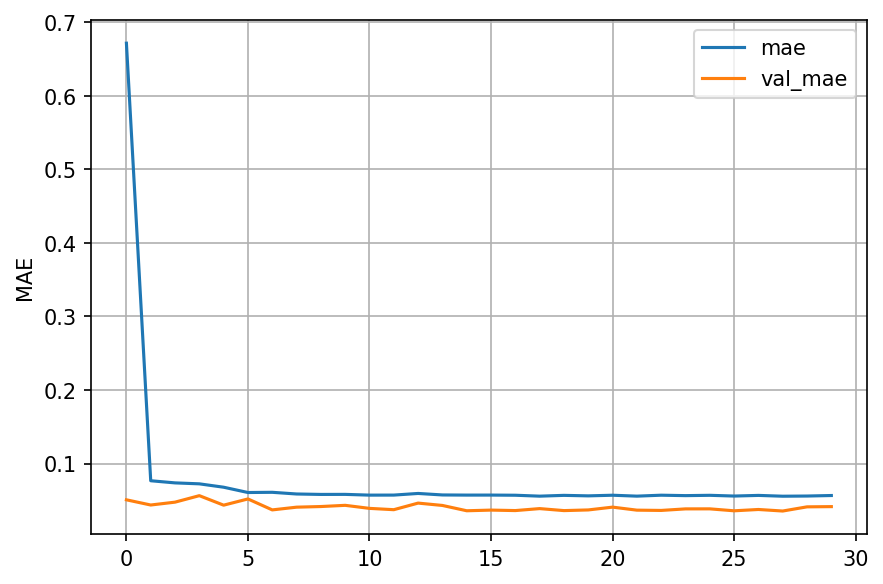

In [488]:
plt.figure()

plt.ylabel("MAE")
plt.plot(hist["mean_absolute_error"], label="mae")
plt.plot(hist["val_mean_absolute_error"], label="val_mae")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [489]:
# Evaluate model
train_preds = model.predict(X_train)
train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
print('Train MAE:', mae(train_preds, y_train.reshape(-1)))

test_preds = model.predict(X_test)
test_preds = np.maximum(test_preds, 0) # Don't predict negative cases

print('Test MAE:', mae(test_preds, y_test.reshape(-1)))

Train MAE: 0.05742910341494083
Test MAE: 0.04144332796873202


In [291]:
model.model.save_weights("weights.h5")

In [251]:
model.model.load_weights("weights.h5")

In [490]:
def convert_ratio_to_new_cases(ratio, window_size, prev_new_cases_list, prev_pct_infected):
    return (ratio * (1 - prev_pct_infected) - 1) * \
           (window_size * np.mean(prev_new_cases_list[-window_size:])) \
           + prev_new_cases_list[-window_size]

def convert_ratios_to_total_cases(ratios, window_size, prev_new_cases, initial_total_cases, pop_size):
    
    new_new_cases = []
    prev_new_cases_list = list(prev_new_cases)
    curr_total_cases = initial_total_cases
    for ratio in ratios:
        new_cases = convert_ratio_to_new_cases(
            ratio,
            window_size,
            prev_new_cases_list,
            curr_total_cases / pop_size
        )
        # new_cases can't be negative!
        new_cases = max(0, new_cases)
        # Which means total cases can't go down
        curr_total_cases += new_cases
        # Update prev_new_cases_list for next iteration of the loop
        prev_new_cases_list.append(new_cases)
        new_new_cases.append(new_cases)
    return new_new_cases

In [491]:
def generate_scenario(geo_id, index=0, test=True, other_cols=None):
    if test:
        df_geo_id = df_test[df_test.GeoID == geo_id]
    else:
        df_geo_id = df_train[df_train.GeoID == geo_id]
    
    if other_cols:
        (X_geo_id, y_geo_id, X_o_geo_id, y_o_geo_id), (X_cols, y_col, o_cols) = dataframe_to_array(
            df_geo_id, 
            nb_lookback_days=nb_lookback_days, 
            nb_lookahead_days=nb_lookahead_days,
            sequence_format=sequence_format, 
            neg_npis=neg_npis, 
            cases_col=CASES_COL,
            other_cols=other_cols
        )
        
        i = index
        X = X_geo_id[i]
        X_o = X_o_geo_id[i]
        
        y_in_true = X[:,:1].flatten()
        y_out_true = y_geo_id[i:].flatten()
        y_o = y_o_geo_id[i:]
        
        
        return X, (y_in_true, y_out_true), (X_o, y_o)
    else:
        (X_geo_id, y_geo_id), (X_cols, y_col) = dataframe_to_array(
            df_geo_id, 
            nb_lookback_days=nb_lookback_days, 
            nb_lookahead_days=nb_lookahead_days,
            sequence_format=sequence_format, 
            neg_npis=neg_npis, 
            cases_col=CASES_COL,
        )

        i = index
        X_input = X_geo_id[i]
        y_in_true = X_input[:,:1].flatten()
        y_out_true = y_geo_id[i:].flatten()

        return X_input, (y_in_true, y_out_true)

In [492]:
def play_scenario(model, X_input, nb_future_days=30, seq=False):
    # Simulate scenario
    X_cases = X_input[:,:1]
    X_npis  = X_input[:,1:]
    X = np.expand_dims(np.concatenate([X_cases,X_npis], axis=1), axis=0)
    y_sim = np.zeros((nb_future_days,))
    
    for d in range(nb_future_days):
        
        if seq:
            y = model.predict(X)[0]
        else:
            y = model.predict(X.reshape(1,-1))[0]
        y_sim[d] = max(y, 0)

        # Assuming constant NPIs here
        X_cases = np.concatenate([X_cases[1:], np.array([[y]])], axis=0)
        
        X_npis = np.concatenate([X_npis[1:], X_npis[-1:]], axis=0)        

        X =  np.expand_dims(np.concatenate([X_cases,X_npis], axis=1), axis=0)
    
    return y_sim

In [493]:
from transat.data.load import load_population
from transat.data.transform import OTHER_COLS
print(OTHER_COLS)
df_pop = load_population()

geoid_to_pop = {geoid:pop for geoid,pop in zip(df_pop.GeoID, df_pop.Population)}

['ProportionInfected', 'SmoothNewCases', 'ConfirmedCases']


In [497]:
geo_id = "France__nan"
nb_future_days = 20*3
X, (y_in_true, y_out_true), (X_o, y_o) = generate_scenario(geo_id, 24, False, OTHER_COLS)
y_pred = play_scenario(model, X, nb_future_days, seq=True)

ratios=y_pred
window_size=1 
prev_new_cases=X_o[:,1]
initial_total_cases=X_o[-1,2]
pop_size = geoid_to_pop[geo_id]
new_cases = convert_ratios_to_total_cases(ratios, window_size, prev_new_cases, initial_total_cases, pop_size)

In [498]:
cum_cases = []
total_cases = initial_total_cases
for nc in new_cases:
    total_cases += nc
    cum_cases.append(total_cases)

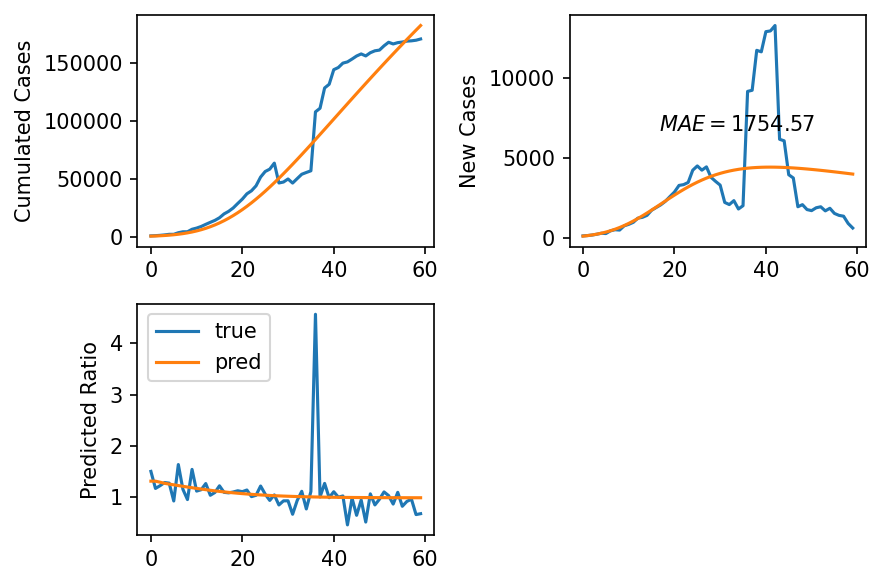

In [499]:
plt.figure()
plt.subplot(2,2,1)
plt.ylabel("Cumulated Cases")
plt.plot(y_o[:,:,2].flatten()[:nb_future_days], label="true")
plt.plot(cum_cases, label="pred")

plt.subplot(2,2,2)

mae_error = mae(y_o[:,:,1].flatten()[:nb_future_days], new_cases)
ax = plt.gca()
plt.text(0.3, 0.5, f"$MAE={mae_error:.2f}$", transform=ax.transAxes)

plt.ylabel("New Cases")
plt.plot(y_o[:,:,1].flatten()[:nb_future_days], label="true")
plt.plot(new_cases, label="pred")

plt.subplot(2,2,3)
plt.ylabel("Predicted Ratio")
plt.plot(y_out_true.flatten()[:nb_future_days], label="true")
plt.plot(y_pred.flatten(), label="pred")

plt.legend()
plt.tight_layout()
plt.show()

In [331]:
def interactive_scenario(geo_id, model, nb_future_days=30, seq=True, index=0, test=True):
    
    if test:
        df_geo_id = df_test[df_test.GeoID == geo_id]
    else:
        df_geo_id = df_train[df_train.GeoID == geo_id]
        
    (X_geo_id, y_geo_id), (X_cols, y_col) = dataframe_to_array(df_geo_id, nb_lookback_days=nb_lookback_days, 
        nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis, cases_col=CASES_COL)
    
    i = index
    X_input = X_geo_id[i]
    input_truth = X_input[:,:1].flatten()
    output_truth = y_geo_id[i:].flatten()
    
    y_sim = play_scenario(model, X_input, nb_future_days=nb_future_days, seq=True)
    
    length = min(len(output_truth), len(y_sim))
    mae_error = mae(output_truth[:length], y_sim[:length])

    plt.figure()
    plt.title(geo_id)
    ax = plt.gca()
    plt.text(0.3, 0.5, f"$MAE={mae_error:.2f}$", transform=ax.transAxes)
    plt.plot(input_truth, label="input truth")
    plt.plot(np.arange(output_truth.shape[0])+input_truth.shape[0], output_truth, alpha=0.5, label="output truth")
    plt.plot(np.arange(y_sim.shape[0])+input_truth.shape[0], y_sim, alpha=1, label="predicted")
    plt.ylabel("Normalized Proportion of New Cases")
    plt.legend()
    plt.show()
    
geo_ids = sorted(df.GeoID.unique())

w_geo_id = widgets.Dropdown(
    options=geo_ids,
    value='France__nan',
    description='GeoID:',
    disabled=False
)

w_nbfd = widgets.IntSlider(
    value=30,
    min=0,
    max=6*31,
    step=1,
    description='Horizon of Future Prediction:',
)

w_index = widgets.IntSlider(
    value=0,
    min=0,
    max=300,
    step=1,
    description='Starting Index:',
)

interact(interactive_scenario, geo_id=w_geo_id, model=fixed(model), seq=fixed(True), index=w_index, nb_future_days=w_nbfd)

interactive(children=(Dropdown(description='GeoID:', index=3, options=('Argentina__nan', 'Brazil__nan', 'Colom…

<function __main__.interactive_scenario(geo_id, model, nb_future_days=30, seq=True, index=0, test=True)>